Estimate Base and Direction of Stack Slope

In [ ]:
import sys
from PyQt5 import QtCore, QtGui, QtWidgets
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg, NavigationToolbar2QT as NavigationToolbar
from matplotlib.figure import Figure
from matplotlib.backend_bases import MouseButton
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
from tifffile import imread
from math import radians, cos, sqrt
import numpy as np

stack_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/rAAV/retr08/"
stack_name = "retr08_000_000_stackred.tif"
stack = imread(stack_path + stack_name)


class MplCanvas(FigureCanvasQTAgg):
    """"""
    def __init__(self, parent=None, width=3, height=3.5, dpi=200):
        """"""
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(MplCanvas, self).__init__(fig)


class MainWindow(QtWidgets.QMainWindow):
    """"""
    def __init__(self, *args, **kwargs):
        """"""
        super(MainWindow, self).__init__(*args, **kwargs)
        sc = MplCanvas(self, width=3, height=3.5, dpi=200)
        # Draw static reference frame
        sc.axes.imshow(stack[0], cmap='gray')
        sc.axes.axis("off")
        # Plot vector base position and direction
        self.arrow_coords = [0, 0, 300, 300]
        self.arrow = sc.axes.arrow(*self.arrow_coords, head_width=10, color="r")

        # Create toolbar
        toolbar = NavigationToolbar(sc, self)
        # Create, configure, and connect to slider for z-stack depth
        self.slider_z = QtWidgets.QSlider(QtCore.Qt.Vertical)
        self.slider_z.setMinimum(0)
        self.slider_z.setMaximum(stack.shape[0]-1)
        self.slider_z.setTickInterval(1)
        self.slider_z.valueChanged.connect(lambda state, ax = sc: self.zsliderValueChange(state, ax))
        self.slider_z.setValue(stack.shape[0]-1)
        # Create, configure, and connect to slider for x-axis position of vector
        self.slider_x = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.slider_x.setMinimum(0)
        self.slider_x.setMaximum(stack.shape[2]-1)
        self.slider_x.setTickInterval(1)
        self.slider_x.valueChanged.connect(lambda state, ax = sc: self.xsliderValueChange(state, ax))
        self.slider_x.setValue(0)
        # Create, configure, and connect to slider for y-axis position of vector
        self.slider_y = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.slider_y.setMinimum(0)
        self.slider_y.setMaximum(stack.shape[1]-1)
        self.slider_y.setTickInterval(1)
        self.slider_y.valueChanged.connect(lambda state, ax = sc: self.ysliderValueChange(state, ax))
        self.slider_y.setValue(0)

        self.dial = QtWidgets.QDial()
        self.dial.setMinimum(-359)
        self.dial.setMaximum(0)
        self.dial.setValue(-45)
        self.dial.setWrapping(True)
        self.dial.valueChanged.connect(lambda state, ax = sc: self.dialValueChange(state, ax))
        
        self.button = QtWidgets.QPushButton()
        self.button.setText("Save")
        self.button.clicked.connect(self.buttonClick)
        
        # Create grid layout
        layout = QtWidgets.QGridLayout()
        # Add matplotlib canvas
        layout.addWidget(sc, 2, 1, 2, 2)
        # Add toolbar
        layout.addWidget(toolbar, 0, 0, 1, 3)
        # Add z-depth slider and labels
        layout.addWidget(self.slider_z, 2, 0, 1, 1, QtCore.Qt.AlignCenter)
        # Add lower slider and labels
        layout.addWidget(self.slider_x, 1, 1, 1, 1, QtCore.Qt.AlignCenter)
        
        layout.addWidget(self.slider_y, 1, 2, 1, 1, QtCore.Qt.AlignCenter)
        
        layout.addWidget(self.dial, 1, 0, 1, 1)
        
        layout.addWidget(self.button, 3, 0, 1, 1)

        # Create a placeholder widget to hold the layout and show
        widget = QtWidgets.QWidget()
        widget.setLayout(layout)
        self.setCentralWidget(widget)
        self.show()
        
    def dialValueChange(self, state, ax):
        """"""
        if -180 <= self.dial.value() <= 0:
            self.arrow.remove()
            angle = radians(-self.dial.value())
            hyp = 424.264
            dy = cos(angle) * hyp
            dx = sqrt(hyp**2 - dy**2)
            self.arrow_coords[2:4] = [dx, dy]
            self.arrow = ax.axes.arrow(*self.arrow_coords, head_width=10, color="r")
            ax.draw()
        elif -359 <= self.dial.value() <= -180:
            self.arrow.remove()
            angle = radians(-self.dial.value())
            hyp = 424.264
            dy = cos(angle) * hyp
            dx = sqrt(hyp**2 - dy**2)
            self.arrow_coords[2:4] = [-dx, dy]
            self.arrow = ax.axes.arrow(*self.arrow_coords, head_width=10, color="r")
            ax.draw()
        
    def xsliderValueChange(self, state, ax):
        """"""
        self.arrow.remove()
        self.arrow_coords[0] = self.slider_x.value()
        self.arrow = ax.axes.arrow(*self.arrow_coords, head_width=10, color="r")
        ax.draw()
        
    def ysliderValueChange(self, state, ax):
        """"""
        self.arrow.remove()
        self.arrow_coords[1] = self.slider_y.value()
        self.arrow = ax.axes.arrow(*self.arrow_coords, head_width=10, color="r")
        ax.draw()
        
    def buttonClick(self):
        """"""
        if -180 <= self.dial.value() <= 0:
            params = [np.abs(self.dial.value())]
        else:
            params = [-(360 + self.dial.value())]
        print(params)
        np.savetxt(stack_path + "angle_params.csv", params)

    def zsliderValueChange(self, state, ax):
        """"""
        ax.axes.images[0].remove()
        im_num = stack.shape[0] - 1 - self.slider_z.value()
        ax.axes.imshow(stack[im_num], cmap='gray')
        ax.draw()


# Start main application window and take screenshot
app = QtCore.QCoreApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
w = MainWindow()
app.exec_()

Plot Uncorrected and Corrected XYZ, XZ, YZ, and XY Volumes

In [ ]:
import glob
import numpy as np
from skimage.measure import label, regionprops
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import pandas as pd
from scipy.spatial.transform import Rotation as R
from math import atan, degrees

# There must be a better way
def get_bbox(xlims, ylims, zlims):
    """"""
    X = []
    Y = []
    Z = []
    for x in xlims:
        for y in ylims:
            for z in zlims:
                X.append(x)
                Y.append(y)
                Z.append(z)
    for x in xlims:
        for z in zlims:
            for y in ylims:
                X.append(x)
                Y.append(y)
                Z.append(z)
    for z in zlims:
        for y in ylims:
            for x in xlims:
                X.append(x)
                Y.append(y)
                Z.append(z)
    return X, Y, Z

def correct_angle(point, dir_angle, dist_angle, slope):
    """"""
    slope_angle = degrees(atan(slope/dist_angle))
    R1 = R.from_euler('z', dir_angle, degrees=True)
    R2 = R.from_euler('x', slope_angle, degrees=True)
    R3 = R.from_euler('z', -dir_angle, degrees=True)
    R_comp = R3 * R2 * R1
    return R_comp.apply(point)

file_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/rAAV/"
exp_names = ["retr07"] # "retr08", "retr09", "retr10", "retr04"
slopes = [120] # 160, 250, 230, -65
dists = [2150] # 2150, 2300, 1900, 1370

for exp, slope, dist in zip(exp_names, slopes, dists):
    
    curr_path = file_path + exp + "/"
    file_name = glob.glob(curr_path + "*.npy")
    in_data = np.load(file_name[0], allow_pickle=True)
    data = in_data.item()
    in_angle = np.loadtxt(glob.glob(curr_path + "*.csv")[0])
    masks = data["masks"]
    regions = regionprops(masks)
    
    fig = make_subplots(
            rows=4, cols=2, 
            specs=[[{'type': 'surface'}, {'type': 'surface'}], 
                   [{'type': 'surface'}, {'type': 'surface'}],
                   [{'type': 'surface'}, {'type': 'surface'}], 
                   [{'type': 'surface'}, {'type': 'surface'}]]
                    )
    
    for col in [1, 2]:
        for row in [1, 2, 3, 4]:
            if col == 1:
                z_range = [0, masks.shape[0]-1]
            elif (col == 2) & (exp != "retr04"):
                z_range = [slope/5, masks.shape[0]-1+(slope/5)]
            else:
                z_range = [-(slope/5), masks.shape[0]-1-(slope/5)]
                
            X, Y, Z = get_bbox([795,0], [0, 899], z_range)
            df = pd.DataFrame(dict(
                X=X, 
                Y=Y, 
                Z=Z,
                line_group=np.repeat(range(int(len(X)/2)), 2)
                             ))
            fig_temp = px.line_3d(df, x='X', y='Y', z='Z', line_group='line_group')
            for line in fig_temp.data:
                fig.add_trace(line, row=row, col=col)
            fig.update_traces(line_color="black", line_width=5, row=row, col=col)
            for region in regions:
                z, y, x = region.centroid
                if col == 2:
                    x, y, z = correct_angle((x, y, z), in_angle, dist, slope)
                fig.add_scatter3d(x=[x], y=[y], z=[z], row=row, col=col)
            fig.update_traces(marker=dict(size=3, opacity=1), row=row, col=col)
            fig.update_scenes(xaxis_range=[796, -1], xaxis_title_text="", xaxis_ticks="", xaxis_zeroline=False, xaxis_showgrid=False, xaxis_showticklabels=False,
                              yaxis_range=[-1, 900], yaxis_title_text="", yaxis_ticks="", yaxis_zeroline=False, yaxis_showgrid=False, yaxis_showticklabels=False,
                              zaxis_title_text="", zaxis_ticks="", zaxis_zeroline=False, zaxis_showgrid=False, zaxis_showticklabels=False,
                             )
        if col == 1:
            fig.layout.scene.zaxis.range = [z_range[0]-1, z_range[1]+1]
            fig.layout.scene3.zaxis.range = [z_range[0]-1, z_range[1]+1]
            fig.layout.scene5.zaxis.range = [z_range[0]-1, z_range[1]+1]
            fig.layout.scene7.zaxis.range = [z_range[0]-1, z_range[1]+1]
        else:
            fig.layout.scene2.zaxis.range = [z_range[0]-1, z_range[1]+1]
            fig.layout.scene4.zaxis.range = [z_range[0]-1, z_range[1]+1]
            fig.layout.scene6.zaxis.range = [z_range[0]-1, z_range[1]+1]
            fig.layout.scene8.zaxis.range = [z_range[0]-1, z_range[1]+1]
    scene_dict = dict(aspectmode="manual", aspectratio=dict(x=13.7, y=17, z=(masks.shape[0]*5)/100))
    fig.update_layout(scene_camera=dict(eye=dict(x=12, y=12, z=0.85)), scene=scene_dict)
    fig.update_layout(scene2_camera=dict(eye=dict(x=12, y=12, z=0.85)), scene2=scene_dict)
    fig.update_layout(scene3_camera=dict(eye=dict(x=0.001, y=19, z=0.001)), scene3=scene_dict)
    fig.update_layout(scene4_camera=dict(eye=dict(x=0.001, y=19, z=0.001)), scene4=scene_dict)
    fig.update_layout(scene5_camera=dict(eye=dict(x=19, y=0.001, z=0.001)), scene5=scene_dict)
    fig.update_layout(scene6_camera=dict(eye=dict(x=19, y=0.001, z=0.001)), scene6=scene_dict)
    fig.update_layout(scene7_camera=dict(eye=dict(x=0.001, y=0.2, z=23)), scene7=scene_dict)
    fig.update_layout(scene8_camera=dict(eye=dict(x=0.001, y=0.2, z=23)), scene8=scene_dict)
    fig.update_layout(width=1600, height=2000, showlegend=False, template="simple_white")
    fig.show("png")
    pio.write_image(fig, curr_path + exp + "_3D_views.png") # , scale=3
    del fig_temp
    del fig

Plot XY Views and Save as SVG

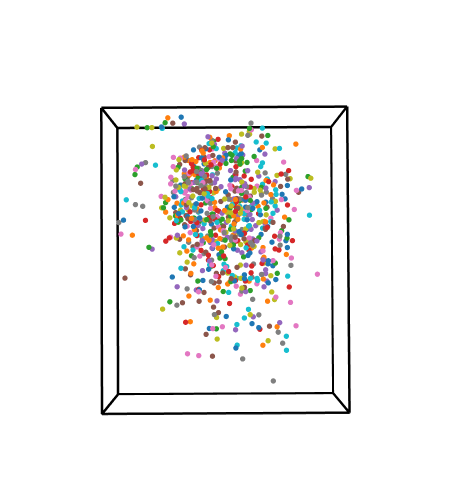

In [14]:
import glob
import numpy as np
from skimage.measure import label, regionprops
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import pandas as pd
from scipy.spatial.transform import Rotation as R
from math import atan, degrees

# There must be a better way
def get_bbox(xlims, ylims, zlims):
    """"""
    X = []
    Y = []
    Z = []
    for x in xlims:
        for y in ylims:
            for z in zlims:
                X.append(x)
                Y.append(y)
                Z.append(z)
    for x in xlims:
        for z in zlims:
            for y in ylims:
                X.append(x)
                Y.append(y)
                Z.append(z)
    for z in zlims:
        for y in ylims:
            for x in xlims:
                X.append(x)
                Y.append(y)
                Z.append(z)
    return X, Y, Z

def correct_angle(point, dir_angle, dist_angle, slope):
    """"""
    slope_angle = degrees(atan(slope/dist_angle))
    R1 = R.from_euler('z', dir_angle, degrees=True)
    R2 = R.from_euler('x', slope_angle, degrees=True)
    R3 = R.from_euler('z', -dir_angle, degrees=True)
    R_comp = R3 * R2 * R1
    return R_comp.apply(point)

file_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/rAAV/"
exp_names = ["retr00", "retr07", "retr08", "retr09", "retr10", "retr04", "retr02"] # 
slopes = [17] # 120, 160, 250, 230, -65, 35] # 
dists = [1370] # 2150, 2150, 2300, 1900, 1370, 1370] # 

for exp, slope, dist in zip(exp_names, slopes, dists):
    
    curr_path = file_path + exp + "/"
    file_name = glob.glob(curr_path + "*.npy")
    in_data = np.load(file_name[0], allow_pickle=True)
    data = in_data.item()
    in_angle = np.loadtxt(glob.glob(curr_path + "*.csv")[0])
    masks = data["masks"]
    regions = regionprops(masks)
    
    fig = make_subplots(
            rows=1, cols=1, 
            specs=[[{'type': 'surface'}]]
                        )
    
    for row in [4]:
        if exp != "retr04":
            z_range = [slope/5, masks.shape[0]-1+(slope/5)]
        else:
            z_range = [-(slope/5), masks.shape[0]-1-(slope/5)]

        X, Y, Z = get_bbox([795,0], [0, 899], z_range)
        df = pd.DataFrame(dict(
            X=X, 
            Y=Y, 
            Z=Z,
            line_group=np.repeat(range(int(len(X)/2)), 2)
                         ))
        fig_temp = px.line_3d(df, x='X', y='Y', z='Z', line_group='line_group')
        for line in fig_temp.data:
            fig.add_trace(line, row=1, col=1)
        fig.update_traces(line_color="black", line_width=5, row=1, col=1)
        for region in regions:
            z, y, x = region.centroid
            x, y, z = correct_angle((x, y, z), in_angle, dist, slope)
            fig.add_scatter3d(x=[x], y=[y], z=[z], row=1, col=1)
        fig.update_traces(marker=dict(size=3, opacity=1), row=1, col=1)
        fig.update_scenes(xaxis_range=[796, -1], xaxis_title_text="", xaxis_ticks="", xaxis_zeroline=False, xaxis_showgrid=False, xaxis_showticklabels=False,
                          yaxis_range=[-1, 900], yaxis_title_text="", yaxis_ticks="", yaxis_zeroline=False, yaxis_showgrid=False, yaxis_showticklabels=False,
                          zaxis_title_text="", zaxis_ticks="", zaxis_zeroline=False, zaxis_showgrid=False, zaxis_showticklabels=False,
                         )
        fig.layout.scene.zaxis.range = [z_range[0]-1, z_range[1]+1]
    scene_dict = dict(aspectmode="manual", aspectratio=dict(x=13.7, y=17, z=(masks.shape[0]*5)/100))
    fig.update_layout(scene_camera=dict(eye=dict(x=0.001, y=0.2, z=23)), scene=scene_dict)
    fig.update_layout(width=450, height=500, showlegend=False, template="simple_white")
    fig.show("png")
    pio.write_image(fig, curr_path + exp + "_XY_view.svg", format="svg") # , scale=3
    del fig_temp
    del fig